In [1]:
import torch
import random
import matplotlib.pyplot as plt
from dataset_util.dataset import BinsceneA
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset
import torch.nn as nn
from tqdm import tqdm
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


BATCH_SIZE = 96
# create an instance of the BinsceneA dataset
binscene_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='full', premultiply_alpha=True)


# display some information on the dataset
print(f'The dataset contains {len(binscene_dataset)} samples.')
print(f'It contains objects from the following {len(binscene_dataset.class_labels)} classes:')
print(binscene_dataset.class_labels, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(binscene_dataset))
# 
img_tensor, object_visibility_vector = binscene_dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(binscene_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of an object visibility vector is:', object_visibility_vector.shape)

The dataset contains 200000 samples.
It contains objects from the following 17 classes:
['cracker_box' 'sugar_box' 'mustard_bottle' 'potted_meat_can' 'banana'
 'bleach_cleanser' 'mug' 'sponge' 'spatula' 'power_drill' 'wood_block'
 'extra_large_clamp' 'softball' 'golf_ball' 'dice' 'toy_airplane'
 'red_box'] 

The shape of an image tensor is: torch.Size([3, 360, 640])
The shape of an object visibility vector is: torch.Size([17])


The shape of the image tensor is: torch.Size([3, 256, 384]) tensor(0.) tensor(1.)
The shape of the object visibility vector is: torch.Size([17])


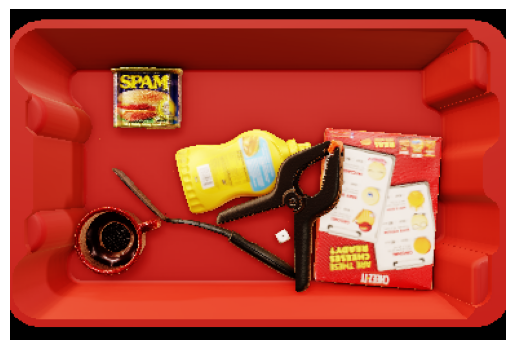

Visible objects are cracker_box, dice, extra_large_clamp, mug, mustard_bottle, potted_meat_can, red_box and spatula.


In [3]:
import torchvision
# we don't need this module to warn us about all kinds of stuff
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import Resize, CenterCrop, Compose, Normalize

# transform is applied to the images, target transform is applied to the visibility vectors
# transformS is applied to a tuple of (image, visibility vector)
# These functions can be defined and chained as desired, but they expect torch tensors as inputs

# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
resize_transform = Resize(size=(90, 160), antialias=True)
crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
norm_transform = Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
image_transform2 = Compose([norm_transform,crop_transform])
image_transform = Compose([resize_transform, crop_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='train', premultiply_alpha=True, 
                                transform=crop_transform)
trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=12,pin_memory=True)
# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset))
img_tensor_new, object_visibility_vector = transformed_dataset.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor_new.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape)
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset.show(img_tensor_new, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

In [4]:


def leaky_relu_init(m, negative_slope=0.2):
    gain = np.sqrt(2.0 / (1.0 + negative_slope ** 2))
    if isinstance(m, torch.nn.Conv1d):
        ksize = m.kernel_size[0]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.Conv2d):
        ksize = m.kernel_size[0] * m.kernel_size[1]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.Conv3d):
        ksize = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.ConvTranspose1d):
        ksize = m.kernel_size[0] // 2
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.ConvTranspose2d):
        ksize = m.kernel_size[0] * m.kernel_size[1] // 4
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.ConvTranspose3d):
        ksize = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] // 8
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * np.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, torch.nn.Linear):
        n1 = m.in_features
        n2 = m.out_features

        std = gain * np.sqrt(2.0 / (n1 + n2))
    else:
        return

    # is_wnw = is_weight_norm_wrapped(m)
    # if is_wnw:
    #     m.fuse()

    m.weight.data.uniform_(-std * np.sqrt(3.0), std * np.sqrt(3.0))
    if m.bias is not None:
        m.bias.data.zero_()


    # blockwise initialization for transposed convs
    if isinstance(m, torch.nn.ConvTranspose2d):
        # hardcoded for stride=2 for now
        m.weight.data[:, :, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2]

    if isinstance(m, torch.nn.ConvTranspose3d):
        # hardcoded for stride=2 for now
        m.weight.data[:, :, 0::2, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 0::2, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 0::2, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2, 0::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2, 0::2]

    # if is_wnw:
        # m.unfuse()

def apply_weight_init_fn(m, fn, negative_slope=1.0):
    should_initialize_weight=True
    if not hasattr(m, "weights_initialized"): #if we don't have this then we need to intiialzie
        # fn(m, is_linear, scale)
        should_initialize_weight=True
    elif m.weights_initialized==False: #if we have it but it's set to false
        # fn(m, is_linear, scale)
        should_initialize_weight=True
    else:
        print("skipping weight init on ", m)
        should_initialize_weight=False

    if should_initialize_weight:
        # fn(m, is_linear, scale)
        fn(m,negative_slope)
        # m.weights_initialized=True
        for module in m.children():
            apply_weight_init_fn(module, fn, negative_slope)

In [5]:
def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=8, num_channels=in_channels, eps=1e-6, affine=True)

In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        
        self.norm1 = Normalize(in_channels)
        self.relu1 = nn.LeakyReLU()
        self.relu2 = nn.LeakyReLU()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = Normalize(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        
    def forward(self, x):
        h = x
        h = self.norm1(h)
        h = self.relu1(h)
        h = self.conv1(h)
        h = self.norm2(h)
        h = self.relu2(h)
        h = self.conv2(h)
        return x + h
        

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, n_channels=1, channels=[16,32,64,128], resnet_num=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, channels[0], kernel_size=2, stride=1),
            nn.LeakyReLU(True),
            nn.Conv2d(channels[0], channels[1], kernel_size=3, stride=2, padding=1),
            ResNetBlock(channels[1], channels[1]),
            ResNetBlock(channels[1], channels[1]),
            ResNetBlock(channels[1], channels[1]),
            nn.LeakyReLU(True),
            nn.Conv2d(channels[1], channels[2], kernel_size=3, stride=2, padding=1),
            ResNetBlock(channels[2], channels[2]),
            ResNetBlock(channels[2], channels[2]),
            ResNetBlock(channels[2], channels[2]),
            nn.LeakyReLU(True),
            nn.Conv2d(channels[2], channels[3], kernel_size=3, stride=2, padding=1),
            ResNetBlock(channels[3], channels[3]),
            ResNetBlock(channels[3], channels[3]),
            ResNetBlock(channels[3], channels[3])
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(channels[3], channels[2], kernel_size=2, stride=2),
            ResNetBlock(channels[2], channels[2]),
            ResNetBlock(channels[2], channels[2]),
            ResNetBlock(channels[2], channels[2]),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(channels[2], channels[0], kernel_size=2, stride=2),
            ResNetBlock(channels[0], channels[0]),
            ResNetBlock(channels[0], channels[0]),
            ResNetBlock(channels[0], channels[0]),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(channels[0], n_channels, kernel_size=2, stride=2),
            nn.Tanh()
        )
        
        
        
        apply_weight_init_fn(self, leaky_relu_init, negative_slope=0.0)
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [8]:
input_s = torch.randn((1,3, 256, 384)).to(device)
model = AutoEncoder(n_channels=3).to(device)
output = model(input_s)
print(output.shape)

torch.Size([1, 3, 256, 384])


In [9]:
input2 = torch.randn((1,3, 256, 384)).to(device)
end_output = model.encoder(input2)
print(end_output.shape)

torch.Size([1, 128, 32, 48])


In [10]:
de_output= model.decoder(end_output)
print(de_output.shape)

torch.Size([1, 3, 256, 384])


In [11]:
learning_rate = 0.001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

In [12]:
from torch.nn.functional import mse_loss as mse
def psnr_rate(input, target):
    return 10.0 * torch.log10(1 / mse(input, target, reduction='mean'))

In [13]:
def evaluate_autoenc(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    

    
    progress_bar = tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False)
    for batch in progress_bar:
        image, mask_true = batch[0], batch[1]

            # move images and labels to correct device and type
        image = image.to(dtype=torch.float32, memory_format=torch.channels_last).to(device)
        
        mask_pred = net(image).to(device)
        psnr = psnr_rate(mask_pred, image)
        print(psnr)
        
        loss = criterion(mask_pred, image)
        
        


    net.train()
    return 

In [14]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    source: https://github.com/openai/guided-diffusion/blob/27c20a8fab9cb472df5d6bdd6c8d11c8f430b924/guided_diffusion/losses.py#L12
    Compute the KL divergence between two gaussians.
    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for torch.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )

In [15]:
def train_model_autoenc(
        model,
        device,
        epochs: int = 200,
        learning_rate: float = 1e-2,
        val_percent: float = 0.1,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        gradient_clipping: float = 1.0,
):
    
    min_loss = 1e25
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)
    for epoch in progress_bar:
        mean_epoch_loss = []
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            image, mask_true = [t.to(device) for t in data]
            progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1, 'Best loss': min_loss}, refresh=True)
            optimizer.zero_grad()
                # move images and labels to correct device and type
            image = image.to(dtype=torch.float32, memory_format=torch.channels_last)

            mask_pred = model(image).to(device)
            batch_mean = torch.mean(image)
            batch_var = torch.var(image)
            loss = criterion(mask_pred, image) + normal_kl(batch_mean,batch_var,0,0)
            mean_epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            
            
            running_loss += loss.item()
        
        loss_mean = np.mean(mean_epoch_loss)
        # scheduler on loss_mean with patience 10 with more aggressive learning rate
        scheduler.step(loss_mean)
        if loss_mean < min_loss:
            min_loss = loss_mean
            torch.save(model, 'autoencoder_binscene.pt')
        if epoch%40==0:
            print('---')
            print(f"Epoch: {epoch} | Train Loss: {loss_mean} | Best Loss: {min_loss}")

                

In [ ]:
train_model_autoenc(model, device)

  0%|                                                                                                                                                    | 0/200 [03:13<?, ?it/s, T of [1667]=606, Best loss=1e+25]